<a href="https://colab.research.google.com/github/mrezaim/Expanse/blob/main/EXPANSE_on_MNIST_using_10_percent_of_first_step_training_data_on_second_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implimentation of verifying the effectiveness of EXPANSE in comparison to the best known DNN on MNIST in case of using only 10% of first step training data.

The details of idea is available in the paper of: Iman, Mohammadreza, Khaled Rasheed, and Hamid Reza Arabnia. “EXPANSE, A Continual Deep Learning System; Research Proposal”, International Conference on Computational Science and Computational Intelligence, IEEE CPS/IEEE Xplore (to appear in April 2022)


Some parts of the following codes are imported (with and without adjustments) from "https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/"


---



First we import all the necessary libraries:

---



In [1]:
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import gdown
import cv2
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from numpy import mean
from numpy import std
# to make the results of different run similar:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

Download and import Train and Test data from MNIST:

---



In [2]:
# Loading the MNIST dataset
#from tensorflow.keras.datasets import mnist
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


Visualize 9 samples of data from MNIST Train dataset:

---



5 0 4 1 9 2 1 3 1 

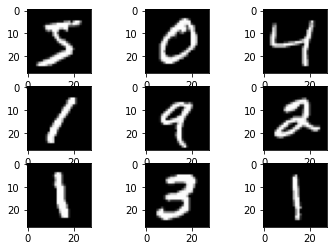

In [3]:
j=0
for i in range(0,9):
  plt.subplot(330 + 1 + j)
  j += 1
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  print (trainy[i], end =" ")
plt.show()

Download the perfect samples pallet. It is a PNG file of 180 perfect samples 
(typed with different fonts).

---



In [4]:
url = 'https://github.com/mrezaim/Expanse/raw/main/perfect_digits.png'
output = 'perfect_digits.png'
gdown.download(url, output, quiet=False)

Downloading...
From: https://github.com/mrezaim/Expanse/raw/main/perfect_digits.png
To: /content/perfect_digits.png
100%|██████████| 26.6k/26.6k [00:00<00:00, 9.23MB/s]


'perfect_digits.png'

Extracting 360 training samples from the perfect samples pallet and creatint train and test dataset by duplicate of samples. 

---



In [5]:
img_path = 'perfect_digits.png'
img = cv2.imread(img_path, 0)
#train_per_x = np.empty_like(trainX)
train_per_x = np.zeros(shape = ( 360, 28, 28 ), dtype=np.uint8)
train_per_y = np.zeros(shape = ( 360), dtype=np.uint8)
i=0
for v in range(18):
  for h in range(10):
    train_per_x[i] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    train_per_y[i] = h
    train_per_x[i+180] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    train_per_y[i+180] = h
    i += 1

print('Perfect train dataset shape:', train_per_x.shape)
print('Perfect train label dataset shape:', train_per_y.shape)


Perfect train dataset shape: (360, 28, 28)
Perfect train label dataset shape: (360,)


Visualize 9 samples of data from perfect train dataset:

---



1 2 3 4 5 6 7 8 9 

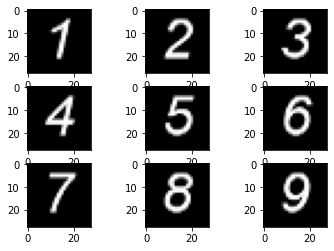

In [6]:
j=0
for i in range(211,220):
  plt.subplot(330 + 1 + j)
  j += 1
  plt.imshow(train_per_x[i], cmap=plt.get_cmap('gray'))
  print (train_per_y[i], end =" ")
plt.show()

Dividing the MNIST train data and Perfect data to two batches of samples of 0-4 and 5-9:

In [7]:
train_x_b1 = np.zeros(shape = ( 30596, 28, 28 ), dtype=np.uint8)
train_y_b1 = np.zeros(shape = ( 30596 ), dtype=np.uint8)
train_x_b2 = np.zeros(shape = ( 29404, 28, 28 ), dtype=np.uint8)
train_y_b2 = np.zeros(shape = ( 29404 ), dtype=np.uint8)
i=0
j=0
k=0
for i in (range(len(trainy))):
  if (trainy[i] == 0 or trainy[i] == 1 or trainy[i] == 2 or trainy[i] == 3 or trainy[i] == 4) :
    train_x_b1[j] = trainX[i]
    train_y_b1[j] = trainy[i]
    j += 1
  else:
    train_x_b2[k] = trainX[i]
    train_y_b2[k] = trainy[i]
    k += 1

print (len(train_y_b1))
print (len(train_y_b2))

30596
29404


In [8]:
train_per_x_b1 = np.zeros(shape = ( 180, 28, 28 ), dtype=np.uint8)
train_per_y_b1 = np.zeros(shape = ( 180 ), dtype=np.uint8)
train_per_x_b2 = np.zeros(shape = ( 180, 28, 28 ), dtype=np.uint8)
train_per_y_b2 = np.zeros(shape = ( 180 ), dtype=np.uint8)
i=0
j=0
k=0
for i in (range(len(train_per_y))):
  if (train_per_y[i] == 0 or train_per_y[i] == 1 or train_per_y[i] == 2 or train_per_y[i] == 3 or train_per_y[i] == 4) :
    train_per_x_b1[j] = train_per_x[i]
    train_per_y_b1[j] = train_per_y[i]
    j += 1
  else:
    train_per_x_b2[k] = train_per_x[i]
    train_per_y_b2[k] = train_per_y[i]
    k += 1

print (len(train_per_y_b1))
print (len(train_per_y_b2))

180
180


Reshape datasets to prepare for the model

---



In [9]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
train_x_b1 = train_x_b1.reshape((train_x_b1.shape[0], 28, 28, 1))
train_x_b2 = train_x_b2.reshape((train_x_b2.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

train_per_x_b1 = train_per_x_b1.reshape((train_per_x_b1.shape[0], 28, 28, 1))
train_per_x_b2 = train_per_x_b2.reshape((train_per_x_b2.shape[0], 28, 28, 1))
train_per_x = train_per_x.reshape((train_per_x.shape[0], 28, 28, 1))

For the second step training we only use 1/10 of first batch of training. We believe if we be able to freez the first step we would need so much less of these samples if none at all.

In [10]:
train_mixX_b3 = np. concatenate((train_per_x,train_x_b1[:3000],train_x_b2), axis=0)
train_mixy_b3 = np. concatenate((train_per_y,train_y_b1[:3000],train_y_b2), axis=0)


Convert the label datasets to categorical since there are 10 possible target categories of digits:

---



In [11]:
# one hot encode target values
trainy = tf.keras.utils.to_categorical(trainy)
train_y_b1 = tf.keras.utils.to_categorical(train_y_b1)
train_y_b2 = tf.keras.utils.to_categorical(train_y_b2)
train_per_y_b1 = tf.keras.utils.to_categorical(train_per_y_b1)
train_per_y_b2 = tf.keras.utils.to_categorical(train_per_y_b2)
testy = tf.keras.utils.to_categorical(testy)

train_per_y = tf.keras.utils.to_categorical(train_per_y)
train_mixy_b3 = tf.keras.utils.to_categorical(train_mixy_b3)

Convert the datasets of images from 8-bit grayscale pixels values to float values and normalize the values to range of 0 and 1:

---



In [12]:
# convert from integers to floats
trainX = trainX.astype('float32')
train_x_b1 = train_x_b1.astype('float32')
train_x_b2 = train_x_b2.astype('float32')
test_X = testX.astype('float32')
train_mixX_b3 = train_mixX_b3.astype('float32')
# normalize to range 0-1
trainX = trainX / 255.0
train_x_b1 = train_x_b1 / 255.0
train_x_b2 = train_x_b2 / 255.0
testX = testX / 255.0
train_mixX_b3 = train_mixX_b3 / 255.0

# convert from integers to floats
train_per_x = train_per_x.astype('float32')
train_per_x_b1 = train_per_x_b1.astype('float32')
train_per_x_b2 = train_per_x_b2.astype('float32')
# normalize to range 0-1
train_per_x = train_per_x / 255.0
train_per_x_b1 = train_per_x_b1 / 255.0
train_per_x_b2 = train_per_x_b2 / 255.0


Defining the small and final model. Here we are using a dense relu based model with Adam optimizer. The final model size is based on the best known DNN model on MNIST with accuracy rate of 98.44 without using preprocessing methods or CNN layers (http://yann.lecun.com/exdb/mnist/).

---



In [13]:
model_small = Sequential()
model_small.add(Flatten())
model_small.add(Dense(300, activation='relu', kernel_initializer='HeUniform', bias_initializer='zeros'))
model_small.add(Dense(200, activation='relu', kernel_initializer='HeUniform', bias_initializer='zeros'))
model_small.add(Dense(5, activation='softmax'))
# compile model
opt = Adam(0.01)
model_small.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model_final = Sequential()
model_final.add(Flatten())
model_final.add(Dense(500, activation='relu', kernel_initializer='HeUniform', bias_initializer='zeros'))
model_final.add(Dense(300, activation='relu', kernel_initializer='HeUniform', bias_initializer='zeros'))
model_final.add(Dense(10, activation='softmax'))
# compile model
opt = Adam(0.002)
model_final.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


The function to run the model on given dataset and parameters using k-fold cross-validation:

---



In [14]:
# evaluate a model using k-fold cross-validation
def evaluate_model(model, dataX, dataY, n_folds, n_epochs, n_batch_size):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch_size, validation_data=(testX, testY))
		# evaluate model
		_, acc = model.evaluate(testX, testY)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories, model

In [15]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
      # plot loss
      plt.subplot(2, 2, 1)
      plt.title('Cross Entropy Loss')
      plt.plot(histories[i].history['loss'], color='blue', label='train')
      plt.plot(histories[i].history['val_loss'], color='orange', label='test')
      # plot accuracy
      plt.subplot(2, 2, 2)
      plt.title('Classification Accuracy')
      plt.plot(histories[i].history['accuracy'], color='blue', label='train')
      plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

Creating the base random intitialized model and save it to reuse for the baseline. We want to use same random weights for comparing different methods fairly:

---



In [16]:
model_small.build((None, 28, 28, 1))
model_small.save("random_init_small")
model_final.build((None, 28, 28, 1))
model_final.save("random_init_final")

INFO:tensorflow:Assets written to: random_init_small/assets
INFO:tensorflow:Assets written to: random_init_final/assets


Creating a list to save each run performance 

---



In [17]:
results = ([])

In [18]:
model_small.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 296,705
Trainable params: 296,705
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
375/375 [==============================] - 7s 16ms/step - loss: 0.2410 - accuracy: 0.9297 - val_loss: 0.1344 - val_accuracy: 0.9575
Epoch 2/5
375/375 [==============================] - 5s 13ms/step - loss: 0.0891 - accuracy: 0.9725 - val_loss: 0.1025 - val_accuracy: 0.9692
Epoch 3/5
375/375 [==============================] - 5s 14ms/step - loss: 0.0554 - accuracy: 0.9831 - val_loss: 0.0856 - val_accuracy: 0.9732
Epoch 4/5
375/375 [==============================] - 5s 13ms/step - loss: 0.0371 - accuracy: 0.9880 - val_loss: 0.0763 - val_accuracy: 0.9757
Epoch 5/5
188/188 [==============================] - 1s 3ms/step - loss: 0.0818 - accuracy: 0.9750
> 97.500
Epoch 1/5
375/375 [==============================] - 5s 14ms/step - loss: 0.0325 - accuracy: 0.9899 - val_loss: 0.0297 - val_accuracy: 0.9903
Epoch 2/5
375/375 [==============================] - 5s 14ms/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.0290 - val_accuracy: 0.9917
Epoch 3/5
375/375 [=====================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


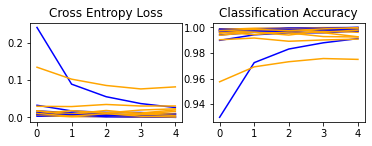

Accuracy: mean=99.408 std=0.705, n=10


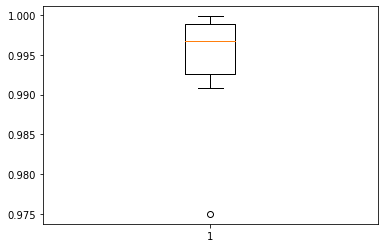

['Random initialized on MNIST with LR=0.0009 & epoch=5', 58.333, 99.992, 98.42]


In [19]:
model = tf.keras.models.load_model("random_init_final")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0009)
scores, histories, model = evaluate_model(model, trainX, trainy,10,5,144)



# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.0009 & epoch=5"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

First step of EXPANSE: train the small model on first batch (0 to 4) of perfect data.

Epoch 1/8
3/3 [==============================] - 1s 95ms/step - loss: 2.1604 - accuracy: 0.1667 - val_loss: 0.8986 - val_accuracy: 0.7778
Epoch 2/8
3/3 [==============================] - 0s 16ms/step - loss: 0.9172 - accuracy: 0.6605 - val_loss: 0.4400 - val_accuracy: 0.8889
Epoch 3/8
3/3 [==============================] - 0s 18ms/step - loss: 0.3875 - accuracy: 0.9074 - val_loss: 0.1807 - val_accuracy: 0.9444
Epoch 4/8
3/3 [==============================] - 0s 17ms/step - loss: 0.1952 - accuracy: 0.9321 - val_loss: 0.1193 - val_accuracy: 0.9444
Epoch 5/8
3/3 [==============================] - 0s 18ms/step - loss: 0.0788 - accuracy: 0.9691 - val_loss: 0.0667 - val_accuracy: 0.9444
Epoch 6/8
3/3 [==============================] - 0s 17ms/step - loss: 0.0160 - accuracy: 0.9938 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/8
3/3 [==============================] - 0s 16ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 8/8
1/1 [===================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


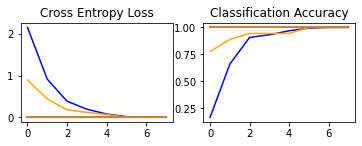

Accuracy: mean=100.000 std=0.000, n=10


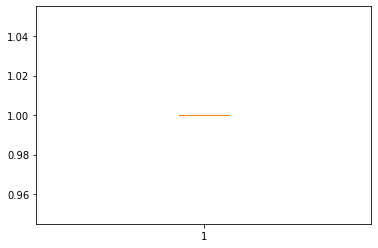

['Random initialized on per_b1 (0 to 4) with LR=0.01 & epoch=8', 100.0, 64.776]


In [20]:
model = tf.keras.models.load_model("random_init_small")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.01)
scores, histories, model = evaluate_model(model, train_per_x_b1, train_per_y_b1,10,8,72)

model.save("trained_perfect_b1")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on per_b1 (0 to 4) with LR=0.01 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x_b1, train_per_y_b1, verbose=0)[1]*100,3),round(model.evaluate(train_x_b1, train_y_b1, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Mixing perfect data and MNIST data of (0 to 4) and finetune the small model with the mix data.

In [21]:
trainmixX_b1 = np. concatenate((train_x_b1, train_per_x_b1), axis=0)
trainmixy_b1 = np. concatenate((train_y_b1, train_per_y_b1), axis=0)
print(trainmixX_b1.shape)
print(trainmixy_b1.shape)


(30776, 28, 28, 1)
(30776, 5)


Epoch 1/8
385/385 [==============================] - 3s 7ms/step - loss: 0.5763 - accuracy: 0.9255 - val_loss: 0.1062 - val_accuracy: 0.9698
Epoch 2/8
385/385 [==============================] - 2s 6ms/step - loss: 0.0820 - accuracy: 0.9758 - val_loss: 0.0544 - val_accuracy: 0.9808
Epoch 3/8
385/385 [==============================] - 2s 6ms/step - loss: 0.0435 - accuracy: 0.9865 - val_loss: 0.0432 - val_accuracy: 0.9867
Epoch 4/8
385/385 [==============================] - 2s 6ms/step - loss: 0.0278 - accuracy: 0.9916 - val_loss: 0.0343 - val_accuracy: 0.9890
Epoch 5/8
385/385 [==============================] - 2s 6ms/step - loss: 0.0188 - accuracy: 0.9945 - val_loss: 0.0326 - val_accuracy: 0.9906
Epoch 6/8
385/385 [==============================] - 2s 6ms/step - loss: 0.0133 - accuracy: 0.9963 - val_loss: 0.0338 - val_accuracy: 0.9886
Epoch 7/8
385/385 [==============================] - 2s 6ms/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.0359 - val_accuracy: 0.9899
Epoch 8/8
97/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


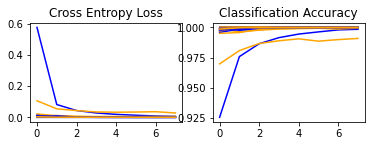

Accuracy: mean=99.893 std=0.268, n=10


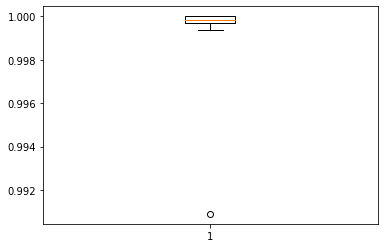

['trained_finetune_mix_b1 on mix data (0 to 4) with LR=0.0005 & epoch=8', 100.0, 100.0]


In [22]:
model = tf.keras.models.load_model("trained_perfect_b1")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0005)
scores, histories, model = evaluate_model(model, trainmixX_b1, trainmixy_b1,10,8,72)

model.save("trained_finetune_mix_b1")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "trained_finetune_mix_b1 on mix data (0 to 4) with LR=0.0005 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x_b1, train_per_y_b1, verbose=0)[1]*100,3),round(model.evaluate(train_x_b1, train_y_b1, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Updating part of random final model with weights from finetuned small size model.

In [23]:
model_small = tf.keras.models.load_model("trained_finetune_mix_b1")
b = model_small.layers[1].get_weights()
a = model_final.layers[1].get_weights()
a[0][:784,:300]=b[0]
a[1][:300]=b[1]
model_final.layers[1].set_weights(a)

b = model_small.layers[2].get_weights()
a = model_final.layers[2].get_weights()
a[0][:300,:200]=b[0]
a[1][:200]=b[1]
model_final.layers[2].set_weights(a)

b = model_small.layers[3].get_weights()
a = model_final.layers[3].get_weights()
a[0][:200,:5]=b[0]
a[1][:5]=b[1]
model_final.layers[3].set_weights(a)

In [24]:
model = model_final
model.layers[3].weights

[<tf.Variable 'dense_5/kernel:0' shape=(300, 10) dtype=float32, numpy=
 array([[ 0.05170976, -0.02273152, -0.32905114, ..., -0.04618773,
         -0.12922554,  0.13178085],
        [-0.04180722, -0.12910551, -0.02858736, ...,  0.04397899,
          0.10153401, -0.12047584],
        [-0.00597238,  0.07139426,  0.0023583 , ...,  0.12067883,
         -0.12364914, -0.01514611],
        ...,
        [ 0.02074444, -0.06549399,  0.09755109, ...,  0.09745234,
         -0.09730152,  0.09756203],
        [-0.02081618,  0.04266517,  0.04235858, ..., -0.08235405,
          0.00250287,  0.00477713],
        [-0.02665937, -0.01693602, -0.02524523, ..., -0.08103518,
         -0.02715031,  0.06878036]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.12388016, -0.11250415,  0.04995216,  0.05853987,  0.02420392,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       dtype=float32)>]

In [25]:
model_final.save('final_model_loaded_weights')
desc = "final_model_loaded_weights without training"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

INFO:tensorflow:Assets written to: final_model_loaded_weights/assets
['final_model_loaded_weights without training', 50.0, 51.08, 51.14]


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 500)               392500    
                                                                 
 dense_4 (Dense)             (None, 300)               150300    
                                                                 
 dense_5 (Dense)             (None, 10)                3010      
                                                                 
Total params: 545,810
Trainable params: 545,810
Non-trainable params: 0
_________________________________________________________________


In [27]:
#model = tf.keras.models.load_model("final_model_loaded_weights")
#from keras import backend as K
#K.set_value(model.optimizer.learning_rate, 0.001)
#scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,5,144)

#model.save("trained_perfectdata")

## learning curves
#summarize_diagnostics(histories)
## summarize estimated performance
#summarize_performance(scores)
#desc = "final_model_loaded_weights on perfect data with LR=0.001 & epoch=5"
#results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
#print (results[len(results)-1]

Because we were not able to freez the small part of the model, applying the two-steps training in this state means catastrophic forgetting. Therefore, we are not using the above training step in our training process.

In [28]:
model.layers[3].weights

[<tf.Variable 'dense_5/kernel:0' shape=(300, 10) dtype=float32, numpy=
 array([[ 0.05170976, -0.02273152, -0.32905114, ..., -0.04618773,
         -0.12922554,  0.13178085],
        [-0.04180722, -0.12910551, -0.02858736, ...,  0.04397899,
          0.10153401, -0.12047584],
        [-0.00597238,  0.07139426,  0.0023583 , ...,  0.12067883,
         -0.12364914, -0.01514611],
        ...,
        [ 0.02074444, -0.06549399,  0.09755109, ...,  0.09745234,
         -0.09730152,  0.09756203],
        [-0.02081618,  0.04266517,  0.04235858, ..., -0.08235405,
          0.00250287,  0.00477713],
        [-0.02665937, -0.01693602, -0.02524523, ..., -0.08103518,
         -0.02715031,  0.06878036]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.12388016, -0.11250415,  0.04995216,  0.05853987,  0.02420392,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       dtype=float32)>]

Epoch 1/5
205/205 [==============================] - 3s 15ms/step - loss: 0.4283 - accuracy: 0.8984 - val_loss: 0.1299 - val_accuracy: 0.9576
Epoch 2/5
205/205 [==============================] - 3s 14ms/step - loss: 0.0922 - accuracy: 0.9711 - val_loss: 0.0876 - val_accuracy: 0.9738
Epoch 3/5
205/205 [==============================] - 3s 14ms/step - loss: 0.0578 - accuracy: 0.9823 - val_loss: 0.0823 - val_accuracy: 0.9741
Epoch 4/5
205/205 [==============================] - 3s 14ms/step - loss: 0.0352 - accuracy: 0.9904 - val_loss: 0.0698 - val_accuracy: 0.9756
Epoch 5/5
103/103 [==============================] - 0s 3ms/step - loss: 0.0663 - accuracy: 0.9774
> 97.742
Epoch 1/5
205/205 [==============================] - 3s 14ms/step - loss: 0.0234 - accuracy: 0.9932 - val_loss: 0.0188 - val_accuracy: 0.9954
Epoch 2/5
205/205 [==============================] - 3s 14ms/step - loss: 0.0114 - accuracy: 0.9971 - val_loss: 0.0125 - val_accuracy: 0.9963
Epoch 3/5
205/205 [=====================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


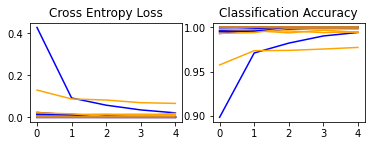

Accuracy: mean=99.649 std=0.666, n=10


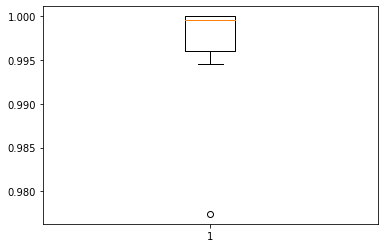

['final_model_loaded_weights on mix data with LR=0.0009 & epoch=5', 100.0, 97.647, 96.55]


In [29]:
model = tf.keras.models.load_model("final_model_loaded_weights")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0009)
scores, histories, model = evaluate_model(model, train_mixX_b3, train_mixy_b3,10,5,144)



# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "final_model_loaded_weights on mix data with LR=0.0009 & epoch=5"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Generating reults and download data:

---



In [30]:
results

[['Random initialized on MNIST with LR=0.0009 & epoch=5',
  58.333,
  99.992,
  98.42],
 ['Random initialized on per_b1 (0 to 4) with LR=0.01 & epoch=8',
  100.0,
  64.776],
 ['trained_finetune_mix_b1 on mix data (0 to 4) with LR=0.0005 & epoch=8',
  100.0,
  100.0],
 ['final_model_loaded_weights without training', 50.0, 51.08, 51.14],
 ['final_model_loaded_weights on mix data with LR=0.0009 & epoch=5',
  100.0,
  97.647,
  96.55]]

In [31]:
import pandas
df=pandas.DataFrame(results,list(range(1, len(results)+1)),["Description","Train perfect", "Train MNIST", "Test MNIST"])
df

,Description,Train perfect,Train MNIST,Test MNIST
1,Random initialized on MNIST with LR=0.0009 & e...,58.333,99.992,98.42
2,Random initialized on per_b1 (0 to 4) with LR=...,100.000,64.776,NaN
3,trained_finetune_mix_b1 on mix data (0 to 4) w...,100.000,100.000,NaN
4,final_model_loaded_weights without training,50.000,51.080,51.14
5,final_model_loaded_weights on mix data with LR...,100.000,97.647,96.55


In [32]:
df.to_csv('results.csv', sep=',', encoding='utf-8')

In [33]:
#!zip -r /content/EXPANSE_Model_Expansion_colab.zip /content

In [34]:
files.download('results.csv') 
#files.download('EXPANSE_Model_Expansion_colab.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'architecture': 'x86_64',
 'hostname': '68c621b035ce',
 'ip-address': '172.28.0.2',
 'mac-address': '02:42:ac:1c:00:02',
 'platform': 'Linux',
 'platform-release': '5.4.188+',
 'platform-version': '#1 SMP Sun Apr 24 10:03:06 PDT 2022',
 'processor': 'x86_64',
 'ram': '13 GB'}